In [23]:
import matplotlib.pyplot as plt
import numpy as np

from utility import *

from scipy.fft import fft, ifft, fftfreq, fftshift
import scipy.signal

from tensorforce.environments import Environment
from tensorforce.agents import Agent

# Radar Environment Setup

In [24]:
# implement the radar environment
class RadarEnvironment(Environment):
    def __init__(self, basis_freqs):
        """[summary]

        Args:
            basis_freqs ([type] Nx1 numpy array): [description] contains N basis angular freqs
            max_timesteps ([type] int ): [description] the maximum number of timesteps per episode
        """

        # define environment hyperparameters (in this case, the hyperparameters are the radar waveform set parameterization)
        self.basis_freqs = basis_freqs
        self.N = self.basis_freqs.size
        self.band_width = np.max(self.basis_freqs) - np.min(self.basis_freqs)
        self.Fs = 2 * self.band_width  # sampling frequency for the radar waveform
        # duration is two periods of the exponential with the smallest freq
        self.duration = (0, 2 * 1.0 / np.min(np.abs(self.basis_freqs)))

        super().__init__()

    def states(self):
        return dict(type='float', shape=(self.N, 1), min_value=-1.0, max_value=1.0)

    # Q: does action have to be discrete??
    def actions(self):
        # 0: -0.1, 1: 0, 2: 0.1
        return dict(type='int', shape=(self.N, 1), num_values =3)

    def action_map(self, actions):
        """[summary] 0: -0.1, 1: 0, 2: 0.1
            e.g. 

            actions repr used by agent: [0 1 2 1 1].T --> actions repr used by the environment [-0.1 0 0.1 0 0].T

        Args:
            actions ([type]): [description] the actions repr used by the agent

        Returns:
            [type]: [description] the actions repr used by the environment
        """
        return -0.1 + 0.1 * actions

    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    def close(self):
        super().close()

    def reset(self):
        self.timestep = 0
        self.current_state = np.random.uniform(
            low=-1.0, high=1.0, size=(self.N, 1))

        return self.current_state

    #####################################################################
    # Utility functions for computing waveform parameters
    #####################################################################

    @staticmethod
    def freqD_to_timeD(state, duration, basis_freqs, Fs):
        """[summary] convert the waveform parameters to its time domain representation

        Args:
            state ([type]): [description] a column vector (2D np array with shape (N, 1))
            duration ([type] a tuple (start_time, end_time)): [description]
            basis_freqs ([type] column vector): [description]
            BW ([type] scalar): [description]
            Fs ([type] scalar): [description]

        Returns:
            [type]: [description] p_b is a row vector, a row vector is a 2-D np array with shape(1, N)
        """

        w = 2*np.pi*basis_freqs

        a = state.T
        t = np.arange(duration[0], duration[1], 1.0/Fs).reshape((1, -1))

        A = w @ t

        p_b = a @ np.exp(1j * A)  # here p_b is a row vector

        return p_b

    @staticmethod
    def point_spread_fn(p_b, Fs):
        """[summary] assume p_b is a row vector. 
            convert the p_b, a time domain repr of the baseband signal, into its point spread function, 
            a complex-valued function

        Args:
            p_b ([type]): [description] a row vector
            Fs ([type]): [description] sampling frequency

        Returns:
            [type]: [description] (t, psf): all row vectors
        """
        (freqs, spectrum) = fourier_spectrum(p_b, Fs)
        psd = np.abs(spectrum) ** 2
        psf = fftshift(ifft(psd))

        N = psf.size
        t = np.linspace(0, N * 1.0 / Fs, N).reshape((1, -1))
        return t, psf

    
    @staticmethod
    def peak_sidelobe_level(psf):
        """[summary]

        Args:
            psf ([type] row vector): [description] row vector with shape (1, N)

        Returns:
            [type]: [description] peak sidelobe level, which is a negative real number.
                    -inf means the best, and 0 means the worst.
        """
        psf_abs = np.abs(psf)
        psf_abs_sorted = np.sort(psf_abs)

        PSL = 20 * np.log10(psf_abs_sorted[0, -2] / psf_abs_sorted[0, -1])
        return PSL

    @staticmethod
    def main_lobe_width(state):
        pass

    ################################################################
    # methods that defines the environment dynamics
    ###################################################################

    # define helper functions used by execute()
    def state_transition(self, actions):
        """[summary]

        Args:
            actions ([type]): [description] At, action repr used by the agent

        Returns:
            [type]: [description] S_(t+1), the next_state of the environment
        """
        actions = self.action_map(
            actions)  # convert action repr used by agent to action repr used by envrionment
        next_state = self.current_state + actions

        # make sure the states values are within range
        next_state[next_state > 1] = 1.0
        next_state[next_state < -1] = -1.0

        return next_state

    def compute_reward(self, state):
        """[summary] Compute the reward associated with the inpute state

        Args:
            state ([type]): [description]
        """
        p_b = RadarEnvironment.freqD_to_timeD(
            state, self.duration, self.basis_freqs, self.Fs)
        (t, psf) = RadarEnvironment.point_spread_fn(p_b, self.Fs)
        PSL = RadarEnvironment.peak_sidelobe_level(
            psf)  # recall it is always a negative scalar

        reward = -PSL
        return reward

    def plot_psf_abs(self, state):

        p_b = RadarEnvironment.freqD_to_timeD(
            state, self.duration, self.basis_freqs, self.Fs)
        (t, psf) = RadarEnvironment.point_spread_fn(p_b, self.Fs)

        plt.plot(t[0], np.abs(psf[0]))
        plt.show()

    def dynamics_fn(self, actions):
        """The dynamics_fn is a blackbox whose input is current_state and action, 
        In this implementation, the current_state is contained in "self", thus, we don't 
        explicitly inlude current_state as input.

        Args:
            actions ([type] N by 1 integer arrays): [description] action repr used by the agent

        Returns:
            (next_state, reward)
        """

        # define helper functions for computing reward: recall the reward R_(t+1) is due to A_t and S_t,
        # thus R_(t + 1) is associated with the reward for state S_(t + 1)

        next_state = self.state_transition(actions)
        reward = self.compute_reward(next_state)

        return next_state, reward

    def execute(self, actions):

        # increment timestep
        self.timestep += 1

        # update the current_state
        self.current_state, self.reward = self.dynamics_fn(actions)

        terminal = False

        return self.current_state, terminal, self.reward


In [25]:
# test area
N = 10
max_episode_length = 100
basis_freqs_10 = np.random.uniform(low=-100, high=100, size=(N, 1))


## Creation of the environment via Environment.create() creates
## a wrapper class around the original Environment defined here.
## That wrapper mainly keeps track of the number of timesteps.
## Environment.create() returns an instance of the wrapped version of your original environment class.

radar_env = Environment.create(environment=RadarEnvironment,
                               max_episode_timesteps=max_episode_length, basis_freqs=basis_freqs_10)


# Agent Setup

## Here we configure a type of agent to learn against this environment. There are many agent configurations to choose from, which we will not cover here. We will not discuss what type of agent to choose here -- we will just take a basic agent to train.

In [26]:
# check the tensorforce agent specs: https://tensorforce.readthedocs.io/en/latest/agents/tensorforce.html
# it includes the discount factor

agent = Agent.create(
    agent='tensorforce', environment=radar_env, update=64,
    optimizer=dict(optimizer='adam', learning_rate=1e-3),
    objective='policy_gradient', reward_estimation=dict(horizon=1)
)


# Check: Untrained Agent Performance
## The agent just initializes a policy and use that policy 

In [27]:
# Initialize
states = radar_env.reset()

internals = agent.initial_internals()
terminal = False


# Run an episode
negative_PSL = []
while not terminal:
    # ask the agent for an actions
    actions, internals = agent.act(states = states, internals = internals, independent=True)

    # apply the actions to the environment
    states, terminal, reward = radar_env.execute(actions=actions)

    # store the reward value
    negative_PSL.append(reward)

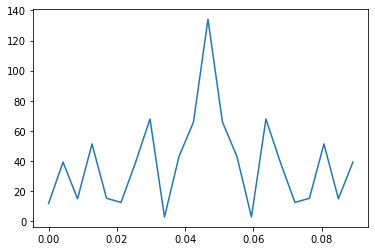

In [28]:
radar_env.plot_psf_abs(states)

# Train the agent

In [29]:
# Train for 200 episodes
for _ in range(200):
    states = radar_env.reset()
    terminal = False
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = radar_env.execute(actions=actions)
        agent.observe(terminal=terminal, reward=reward)

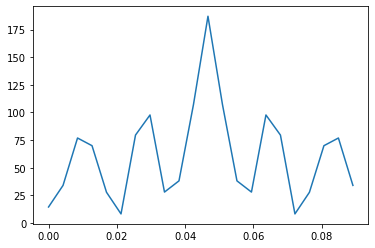

In [30]:
radar_env.plot_psf_abs(states)

In [31]:
states

array([[-1.        ],
       [-0.81089887],
       [ 1.        ],
       [ 1.        ],
       [ 0.0346796 ],
       [ 1.        ],
       [ 1.        ],
       [ 1.        ],
       [-1.        ],
       [ 0.4160496 ]])

# Trained Agent Performance